In [92]:
%load_ext autoreload
%autoreload 2
%aimport anndata
%aimport os
%aimport torch
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
from typing import Dict, Union, List, Tuple
from torch.utils.data import Dataset
# Control UMAP numba warnings
import warnings; warnings.simplefilter('ignore')
import copy
import scvi
from scvi.dataset import cortex
from scvi.models import VAE
from scvi.inference import UnsupervisedTrainer, load_posterior
from scvi import set_seed
from scvi.dataset import setup_anndata

#STUFF THAT I MESSED AROUND WITH
# from BioDataset import BioDataset
# from constants import X_KEY, BATCH_KEY, LOCAL_L_MEAN_KEY, LOCAL_L_VAR_KEY, LABELS_KEY

# Sets torch and numpy random seeds, run after all scvi imports
set_seed(0)


[2020-07-07 11:35:22,592] INFO - scvi._settings | 'scvi' logger already has a StreamHandler, set its level to 20.


[autoreload of scvi.dataset._anndata failed: Traceback (most recent call last):
  File "/Users/galen/anaconda3/envs/scvi/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/Users/galen/anaconda3/envs/scvi/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/Users/galen/anaconda3/envs/scvi/lib/python3.6/imp.py", line 315, in reload
    return importlib.reload(module)
  File "/Users/galen/anaconda3/envs/scvi/lib/python3.6/importlib/__init__.py", line 166, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 618, in _exec
  File "<frozen importlib._bootstrap_external>", line 678, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/Users/galen/scVI/scvi/dataset/_anndata.py", line 9, in <module>
    from scvi.dataset._utils import (
ImportError: canno

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from scvi.dataset.dataset import   GeneExpressionDataset
from scvi.dataset.anndataset import DownloadableAnnDataset
save_path = "data/"
dataset1 = DownloadableAnnDataset(
    "pbmc_10k_protein.h5ad",
    save_path=save_path,
    url="https://github.com/YosefLab/scVI-data/raw/master/pbmc_10k_protein_v3.h5ad?raw=true",
    cell_measurements_col_mappings={"protein_expression":"protein_names"},
)

dataset2 = DownloadableAnnDataset(
    "pbmc_5k_protein.h5ad",
    save_path=save_path,
    url="https://github.com/YosefLab/scVI-data/raw/master/pbmc_5k_protein_v3.h5ad?raw=true",
    cell_measurements_col_mappings={"protein_expression":"protein_names"},
)

[2020-07-01 19:26:48,996] INFO - scvi.dataset.dataset | File /Users/galen/scVI/galen/data/pbmc_10k_protein.h5ad already downloaded
[2020-07-01 19:26:50,677] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-07-01 19:26:50,678] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-07-01 19:26:52,044] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-01 19:26:52,438] INFO - scvi.dataset.dataset | Downsampled from 6855 to 6855 cells
[2020-07-01 19:26:52,473] INFO - scvi.dataset.dataset | File /Users/galen/scVI/galen/data/pbmc_5k_protein.h5ad already downloaded
[2020-07-01 19:26:53,631] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-07-01 19:26:53,632] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-07-01 19:26:54,441] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-01 19:26:54,643] INFO - scvi.dataset.dataset | Downsampled from 3994 to 3994 cells


In [4]:
from scvi.models import TOTALVI
from scvi.inference import TotalPosterior, TotalTrainer

In [5]:
# concatenate the datasets
dataset = GeneExpressionDataset()
dataset.populate_from_datasets([dataset1, dataset2])
dataset.subsample_genes(4000)

[2020-07-01 19:26:54,732] INFO - scvi.dataset.dataset | Merging datasets. Input objects are modified in place.
[2020-07-01 19:26:54,733] INFO - scvi.dataset.dataset | Gene names and cell measurement names are assumed to have a non-null intersection between datasets.
[2020-07-01 19:26:54,764] INFO - scvi.dataset.dataset | Keeping 15792 genes
[2020-07-01 19:26:57,104] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-01 19:26:58,314] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-07-01 19:26:58,315] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-07-01 19:26:59,667] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-01 19:27:00,305] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-07-01 19:27:00,306] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-07-01 19:27:03,354] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-07-01 19:27:03,356] INFO - 

In [75]:
adata = dataset.to_anndata()

In [6]:
adata.shape

(10849, 4000)

In [15]:
adata.obsm['protein_expression'].shape

(10849, 14)

In [28]:
import string
names = string.ascii_lowercase[:14]
names = [i for i in names]
print(names)
adata.uns['protein_names'] = names
new = anndata.AnnData(X = adata.X, obs = adata.obs, obsm = pd.DataFrame(data = adata.obsm['protein_expression'], index = [int(i) for i in adata.obs_names], columns = names) )

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n']


In [8]:
pd.DataFrame(data = adata.obsm['protein_expression'], columns = names)

,a,b,c,d,e,f,g,h,i,j,k,l,m,n
0,7,491,61,17,3,9,18,110,74,138,17,13,9,4
1,8,472,102,155,3,5,30,125,156,119,248,19,9,9
2,12,1289,128,72,8,15,18,5268,28,207,26,10,20,11
3,16,20,124,1227,5,15,18,4743,28,11,491,17,25,59
4,17,19,156,1873,4,16,5,4108,21,14,458,14,28,76
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10844,60,6,11,0,4,3,756,302,11,1237,4,2,5,0
10845,2,475,9,4,7,8,21,25,44,219,1,12,7,1
10846,7,15,6,1,1,6,693,57,69,9,2,737,34,14
10847,145,9,14,2,2,3,402,6,184,1417,5,8,11,2


In [29]:
adata.obs_names


Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '10839', '10840', '10841', '10842', '10843', '10844', '10845', '10846',
       '10847', '10848'],
      dtype='object', length=10849)

In [49]:
adata.obs_names = [int(i) for i in adata.obs_names]

AnnData expects .obs.index to contain strings, but your first indices are: Int64Index([0, 1], dtype='int64'), …


In [50]:
new = anndata.AnnData(X = adata.X, obs = adata.obs, obsm = pd.DataFrame(data = adata.obsm['protein_expression'], index = [int(i) for i in adata.obs_names], columns = names) )

ValueError: value.index does not match parent’s axis 0 names

In [77]:
import pandas as pd

adata.obsm['protein_expression'] =pd.DataFrame(data = adata.obsm['protein_expression'], index = adata.obs_names, columns = names) 

In [51]:
a = pd.DataFrame(data = adata.obsm['protein_expression'], index = adata.obs_names, columns = names) 

In [78]:
adata

AnnData object with n_obs × n_vars = 10849 × 4000
    obs: 'cell_types', 'n_genes', 'n_counts', 'percent_mito', 'batch_indices', '_scvi_labels', '_scvi_local_l_mean', '_scvi_local_l_var'
    var: 'hvg_encode', 'encode', 'n_cells', 'highly_variable'
    uns: 'cell_measurements_col_mappings', 'protein_names', 'scvi_data_registry', 'scvi_summary_stats'
    obsm: 'protein_expression'

In [80]:
isinstance(adata.obsm['protein_expression'], pd.DataFrame)

True

In [79]:
setup_anndata(adata, protein_expression_obsm_key = 'protein_expression', batch_key = 'batch_indices', )

[2020-07-01 22:50:37,794] INFO - scvi.dataset._anndata | Using data from adata.X
[2020-07-01 22:50:37,795] INFO - scvi.dataset._anndata | Using batches from adata.obs["batch_indices"]
[2020-07-01 22:50:37,795] INFO - scvi.dataset._anndata | No label_key inputted, assuming all cells have same label
[2020-07-01 22:50:37,798] INFO - scvi.dataset._anndata | Computing library size prior per batch
[2020-07-01 22:50:37,875] INFO - scvi.dataset._anndata | Successfully registered anndata object containing 10849 cells, 4000 genes, and 2 batches 
Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels', 'protein_expression']


In [81]:
adata

AnnData object with n_obs × n_vars = 10849 × 4000
    obs: 'cell_types', 'n_genes', 'n_counts', 'percent_mito', 'batch_indices', '_scvi_labels', '_scvi_local_l_mean', '_scvi_local_l_var'
    var: 'hvg_encode', 'encode', 'n_cells', 'highly_variable'
    uns: 'cell_measurements_col_mappings', 'protein_names', 'scvi_data_registry', 'scvi_summary_stats'
    obsm: 'protein_expression'

In [82]:
adata.uns['scvi_summary_stats']

{'n_batch': 2,
 'n_cells': 10849,
 'n_genes': 4000,
 'n_labels': 1,
 'n_proteins': 14,
 'protein_names': ['a',
  'b',
  'c',
  'd',
  'e',
  'f',
  'g',
  'h',
  'i',
  'j',
  'k',
  'l',
  'm',
  'n']}

In [89]:
test_mode = False

totalvae = TOTALVI(
    adata.uns['scvi_summary_stats']['n_genes'], 
    adata.uns['scvi_summary_stats']['n_proteins'], 
    0
#     adata.uns['scvi_summary_stats']['n_batch'],
)
use_cuda = True
lr = 4e-3
n_epochs = 500

# totalVI is trained on 90% of the data
# Early stopping does not comply with our automatic notebook testing so we disable it when testing
trainer = TotalTrainer(
    totalvae,
    adata,
    train_size=0.90,
    test_size=0.10,
    use_cuda=use_cuda,
    frequency=1,
    batch_size=256,
    early_stopping_kwargs="auto" if not test_mode else None
)

In [90]:
trainer.train(n_epochs = 1)

[2020-07-01 22:54:43,312] INFO - scvi.inference.inference | KL warmup phase may exceed overall training phase.If your applications rely on posterior quality, consider training for more epochs or reducing the kl warmup.
[2020-07-01 22:54:43,312] INFO - scvi.inference.inference | KL warmup for 8136.75 iterations



[2020-07-01 22:54:59,555] INFO - scvi.inference.inference | Training is still in warming up phase. If your applications rely on the posterior quality, consider training for more epochs or reducing the kl warmup.


In [91]:
# create posterior on full data
# this by default uses the scVI dataset object and the model used for training
full_posterior = trainer.create_posterior(type_class=TotalPosterior)
# full_posterior = full_posterior.update({"batch_size":32})

# extract latent space
latent_mean, batch_index, label, library_gene = full_posterior.get_latent()

# Number of Monte Carlo samples to average over
n_samples = 25
# Probability of background for each (cell, protein)
py_mixing = full_posterior.get_sample_mixing(n_samples=n_samples, give_mean=True, transform_batch=[0, 1])
parsed_protein_names = [p.split("_")[0] for p in dataset.protein_names]
protein_foreground_prob = pd.DataFrame(
    data=(1 - py_mixing), columns=parsed_protein_names
)

denoised_genes, denoised_proteins = full_posterior.get_normalized_denoised_expression(
    n_samples=n_samples, give_mean=True, transform_batch=[0, 1]
)

In [14]:
post_adata = anndata.AnnData(X=dataset.X)
post_adata.var_names = dataset.gene_names
# put the denoised genes in the adata object
post_adata.raw = post_adata
post_adata.X = denoised_genes

In [15]:
import scanpy as sc
post_adata.obsm["X_totalVI"] = latent_mean
sc.pp.neighbors(post_adata, use_rep="X_totalVI", n_neighbors=30, metric="correlation")
sc.tl.umap(post_adata, min_dist=0.4)
sc.tl.leiden(post_adata, key_added="leiden_totalVI", resolution=0.7)

In [37]:
scanpy_labels = post_adata.obs.leiden_totalVI.to_numpy(dtype=int)

per_cluster_de, cluster_id = full_posterior.one_vs_all_degenes(
    cell_labels=scanpy_labels,
    min_cells=1,
    n_samples=5000,
    use_permutation=False,
    mode="change",
    delta=0.2
)

KeyError: "None of [Int64Index([5469, 2679, 6622, 3255, 4199, 5171, 3403, 2025, 6345, 4822,\n            ...\n            2801, 3156, 3035, 2984, 4815, 6292, 4423, 4811,    9, 5120],\n           dtype='int64', length=256)] are in the [columns]"

In [17]:
print(len(per_cluster_de))
print(cluster_id)

24
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]


In [18]:
per_cluster_de[0].head(10)


,proba_de,proba_not_de,bayes_factor,scale1,scale2,lfc_mean,lfc_median,lfc_std,lfc_min,lfc_max,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,clusters
IL32,0.8206,0.1794,1.520418,0.000893,0.000637,0.580058,0.584172,0.684369,-1.009637,1.677030,2.115927,2.927057,0.802419,0.529674,19.426214,15.894884,0
TMSB4X,0.8038,0.1962,1.410216,0.001461,0.001569,-0.072078,-0.128956,0.552404,-1.340227,1.161903,23.318548,50.541847,0.997984,0.999493,214.726944,161.538574,0
TRAC,0.7870,0.2130,1.306936,0.000723,0.000518,0.598435,0.462573,0.682796,-0.792518,1.795626,2.842742,1.835751,0.876008,0.468500,26.334366,10.230330,0
CD8A,0.7810,0.2190,1.271503,0.000623,0.000476,0.438273,0.450466,0.501211,-0.719441,1.221544,0.248992,0.216597,0.138105,0.098712,1.774629,1.194764,0
CD69,0.7734,0.2266,1.227610,0.000817,0.000622,0.451995,0.433952,0.524569,-0.778601,1.376827,1.255040,1.407426,0.620968,0.478949,11.743255,7.094467,0
CCL5,0.7730,0.2270,1.225329,0.000884,0.000659,0.488146,0.516239,0.584554,-0.892110,1.408949,0.149194,3.205945,0.037298,0.314802,1.245885,15.996855,0
CLEC10A,0.7660,0.2340,1.185861,0.000210,0.000277,-0.365266,-0.378051,0.439242,-1.047955,0.744452,0.000000,0.306584,0.000000,0.058131,0.000000,0.271206,0
CST7,0.7658,0.2342,1.184746,0.000698,0.000519,0.495465,0.497313,0.554588,-0.751572,1.414657,0.022177,1.074769,0.015121,0.273410,0.190077,5.491057,0
NOSIP,0.7638,0.2362,1.173627,0.000704,0.000548,0.404969,0.416115,0.451158,-0.678622,1.110021,2.147177,1.049508,0.824597,0.504312,19.480576,5.375587,0
KLRD1,0.7568,0.2432,1.135215,0.000666,0.000498,0.477457,0.530252,0.550588,-0.761455,1.404327,0.010081,0.701329,0.007056,0.184437,0.088735,3.559420,0


In [19]:
filtered_pro = []
filtered_rna = []
for i, cid in enumerate(cluster_id):
    pcd = per_cluster_de[i].sort_values("lfc_median", ascending=False)

    pcd = pcd[pcd.lfc_median > 0]

    pro_rows = pcd.index.str.contains('TotalSeqB')
    data_pro = pcd.iloc[pro_rows]
    data_pro = data_pro[data_pro["bayes_factor"] > 0.7]

    data_rna = pcd.iloc[~pro_rows]
    data_rna = data_rna[data_rna["bayes_factor"] > 0.7]
    data_rna = data_rna[data_rna["non_zeros_proportion1"] > 0.1]

    filtered_pro.append(data_pro)
    filtered_rna.append(data_rna)

In [20]:
def plot_ranked_features(per_cluster_de_filtered, n_features=10):
    """Code inspired by scanpy pl.rank_genes_groups function (and parts borrowed)
        https://github.com/theislab/scanpy/blob/d47d373e96fed96a40186f258ec81994534fd1cc/scanpy/plotting/_tools/__init__.py#L215-L325
    """

    from matplotlib import gridspec
    from matplotlib import rcParams
    n_panels_x = 4
    n_panels_y = np.ceil(len(cluster_id) / n_panels_x).astype(int)

    fig = plt.figure(figsize=(n_panels_x * rcParams['figure.figsize'][0],
                                n_panels_y * rcParams['figure.figsize'][1]))
    gs = gridspec.GridSpec(nrows=n_panels_y,
                        ncols=n_panels_x,
                        wspace=0.22,
                        hspace=0.3)

    ymin = np.Inf
    ymax = -np.Inf
    for count, df in enumerate(per_cluster_de_filtered):


        ax = fig.add_subplot(gs[count])

        gene_names = df.index
        scores = df["lfc_median"].values
        for ig, g in enumerate(gene_names[:n_features]):
            gene_name = gene_names[ig]
            ax.text(
                ig, scores[ig],
                gene_name,
                rotation='vertical', verticalalignment='bottom',
                horizontalalignment='center', fontsize=11)

        if count >= n_panels_x * (n_panels_y - 1):
            ax.set_xlabel('ranking')

        if count % n_panels_x == 0:
            ax.set_ylabel('score')

        ax.set_title('{} vs. {}'.format(count, "all"))

        if len(scores) > 0:
            ax.set_xlim(-0.9, ig + 1-0.1)
            ymin = np.min(scores)
            ymax = np.max(scores)
            ymax += 0.3*(np.max(scores)-np.min(scores))
            ax.set_ylim(ymin, ymax)
        else:
            ax.set_xlim(0, 1)

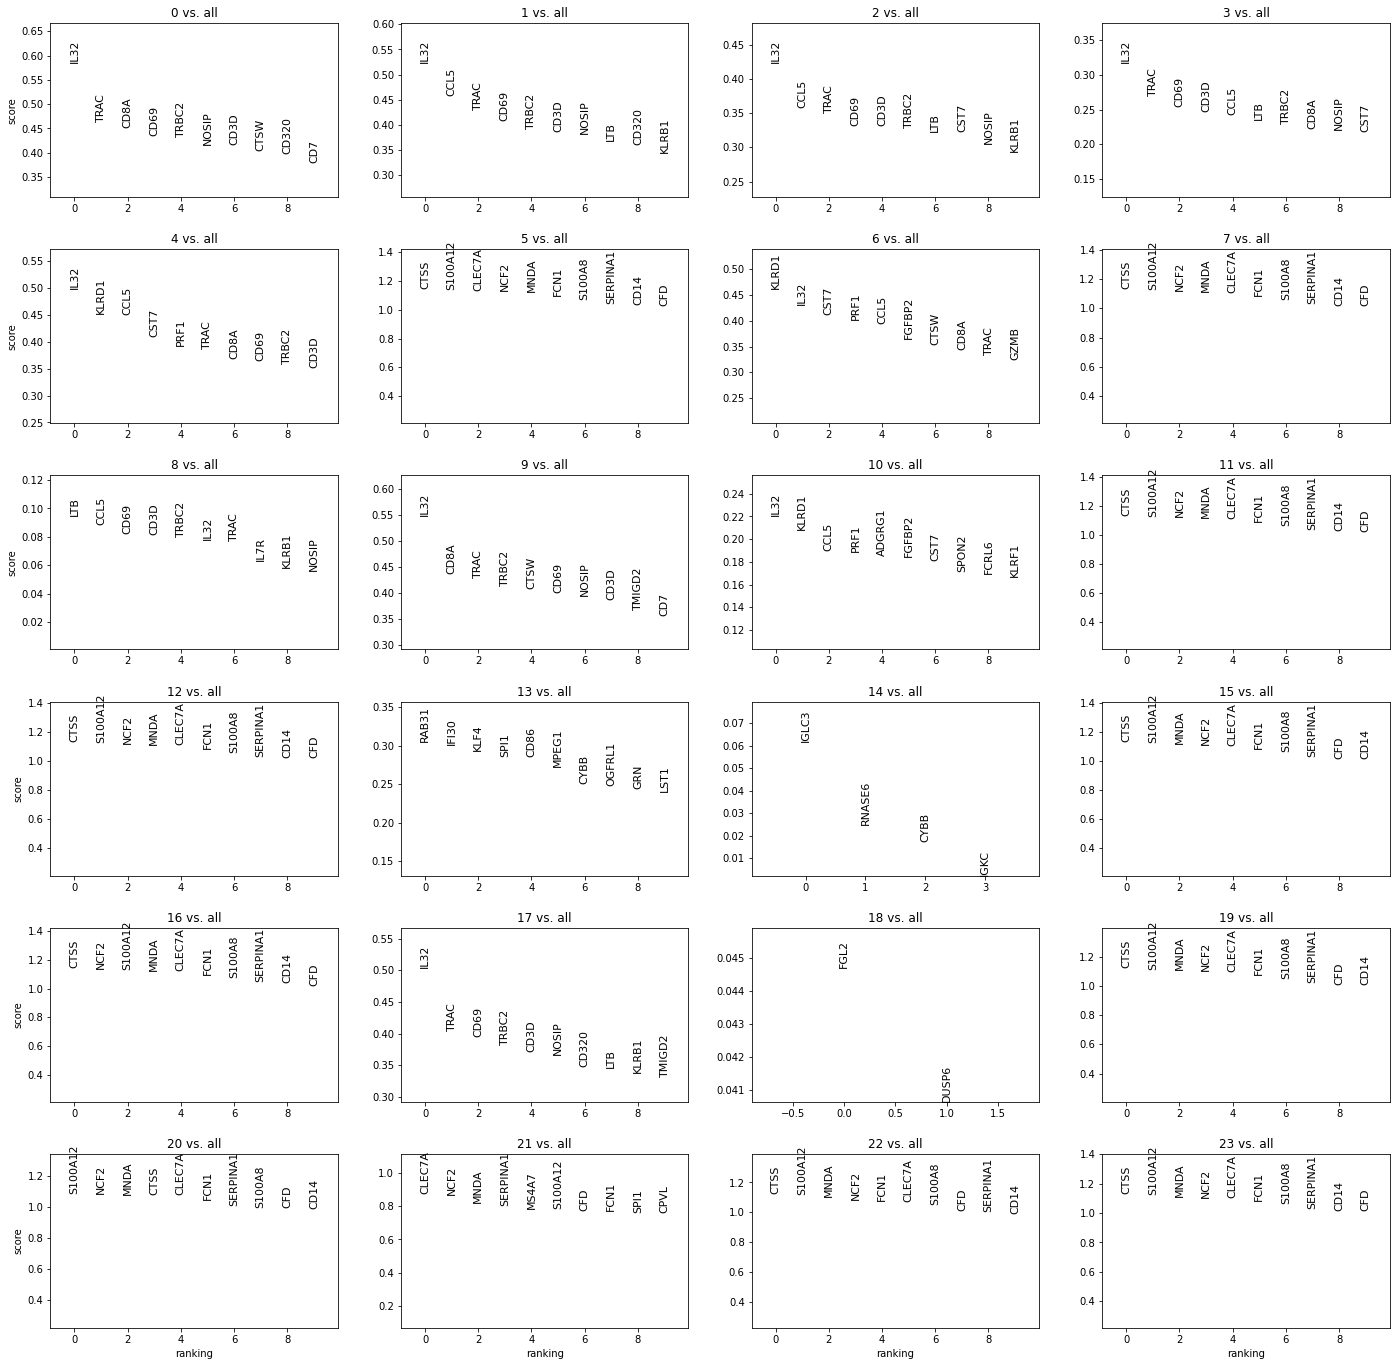

In [21]:
%matplotlib inline
plot_ranked_features(filtered_rna)


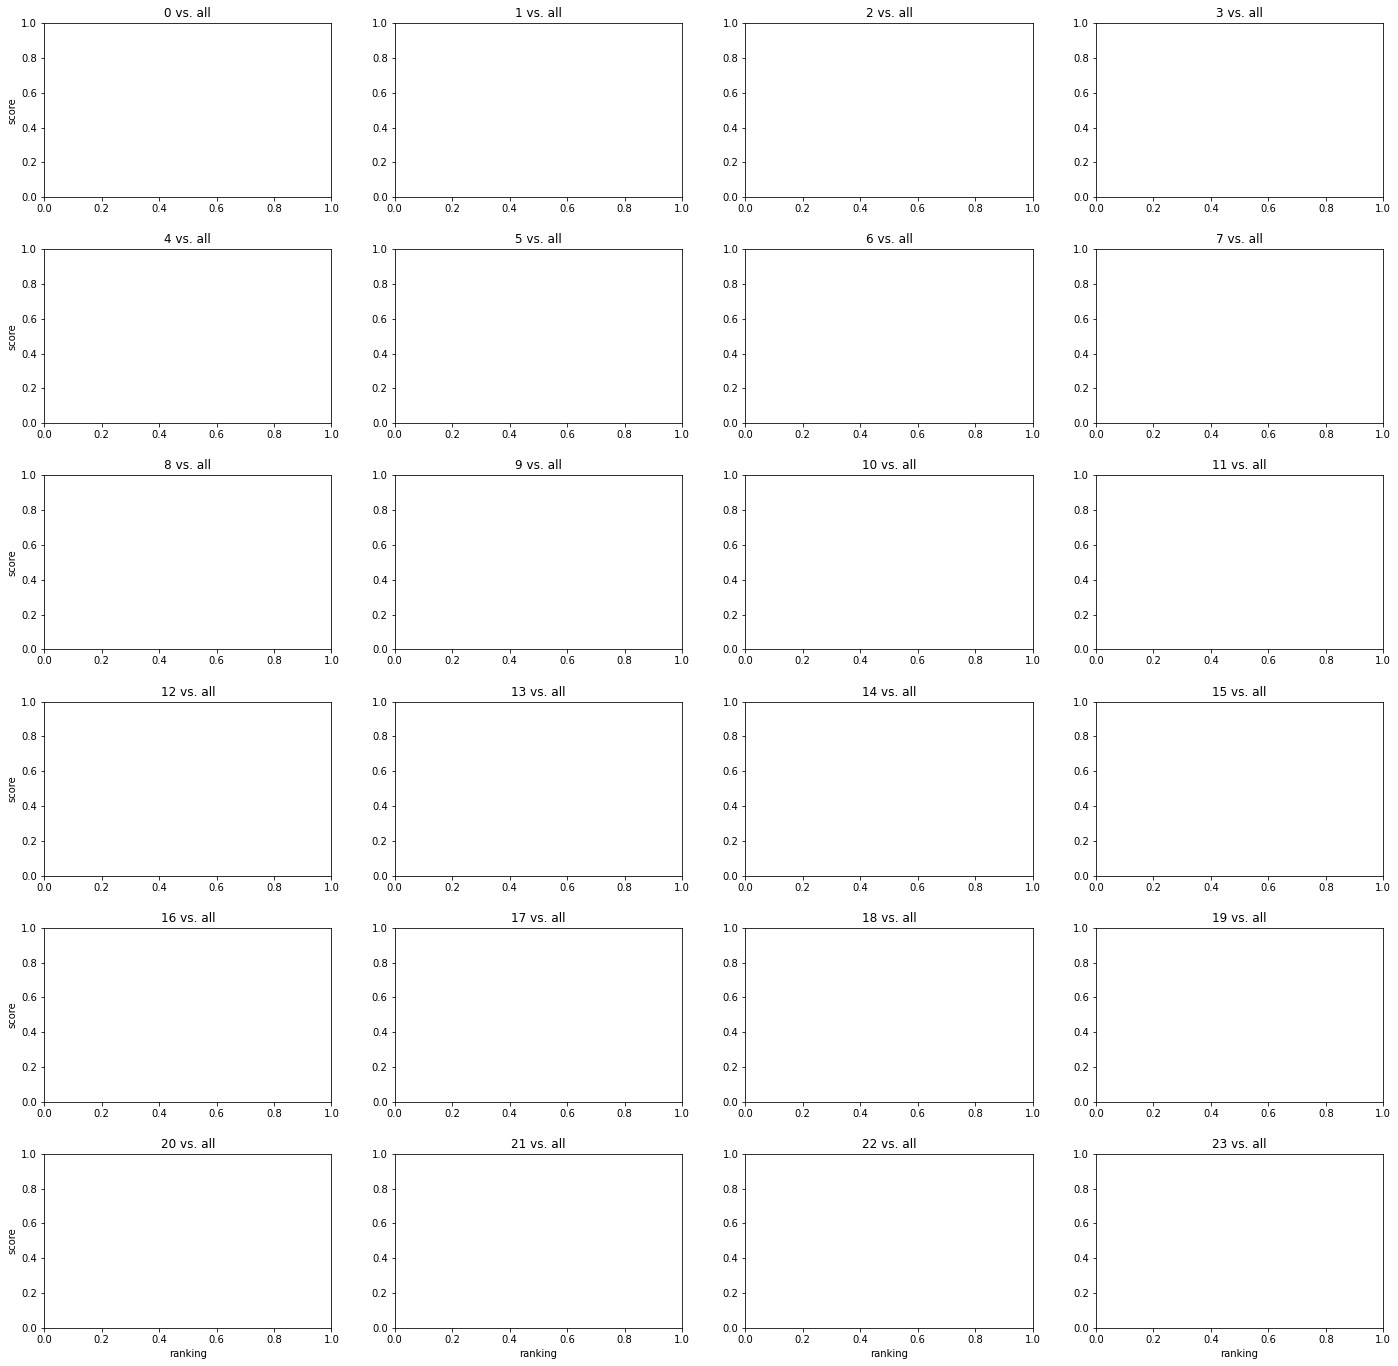

In [22]:
plot_ranked_features(filtered_pro)


In [23]:
sc.pl.matrixplot(
    pro_adata,
    pro_adata.var["protein_names"],
    groupby="leiden_totalVI",
    gene_symbols="protein_names",
    dendrogram=True,
    swap_axes=True,
    use_raw=False,
    cmap="Greens",
    standard_scale="var"
)

NameError: name 'pro_adata' is not defined